# Building a Neural Network from Scratch

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 

### Abstract Base Class : Layer
The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [1]:

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In the abstract class above, backward_propagation function has an extra parameter, learning_rate, which is controlling the amount of learning/updating parameters using gradient descent.

### Backward Propagation
Suppose we have a matrix containing the derivative of the error with respect to that layer’s output: $\frac{\partial E}{\partial Y}$

We need :
- The derivative of the error with respect to the parameters ($\frac{\partial E}{\partial W}$, $\frac{\partial E}{\partial B}$)
- The derivative of the error with respect to the input ($\frac{\partial E}{\partial X}$)

Let's calculate $\frac{\partial E}{\partial W}$. This matrix should be the same size as $W$ itself : 

$i x j$ where $i$ is the number of input neurons and $j$ the number of output neurons. We need one gradient for every weight

### Coding the Fully Connected Layer

In [2]:
#from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of edges that connects to neurons in next layer
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

### Activation Layer
All the calculation we did until now were completely linear, may not learn well. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

Now we need to redo the whole process for this new type of layer!

In [3]:
#from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

You can also write some activation functions and their derivatives in a separate file. These will be used later to create an ActivationLayer.

In [4]:
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

### Loss Function
Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.
The error of the network, which measures how good or bad the network did for a given input data, is defined by you. 

There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

In [5]:

import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

### Network Class
Almost done ! We are going to make a Network class to create neural networks very easily using the building blocks we have prepared so far.


In [6]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [7]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

        
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network 
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        '''
        Fit function does the training. 
        Training data is passed 1-by-1 through the network layers during forward propagation.
        Loss (error) is calculated for each input and back propagation is performed via partial 
        derivatives on each layer.
        '''
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

### Building Neural Networks
Finally ! We can use our class to create a neural network with as many layers as we want ! We are going to build two neural networks : a simple XOR and a MNIST solver.


### Solve XOR
Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [8]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

epoch 1/1000   error=0.742841
epoch 2/1000   error=0.364969
epoch 3/1000   error=0.309990
epoch 4/1000   error=0.299417
epoch 5/1000   error=0.296200
epoch 6/1000   error=0.294811
epoch 7/1000   error=0.294012
epoch 8/1000   error=0.293440
epoch 9/1000   error=0.292964
epoch 10/1000   error=0.292530
epoch 11/1000   error=0.292115
epoch 12/1000   error=0.291705
epoch 13/1000   error=0.291295
epoch 14/1000   error=0.290881
epoch 15/1000   error=0.290460
epoch 16/1000   error=0.290031
epoch 17/1000   error=0.289591
epoch 18/1000   error=0.289139
epoch 19/1000   error=0.288674
epoch 20/1000   error=0.288193
epoch 21/1000   error=0.287696
epoch 22/1000   error=0.287181
epoch 23/1000   error=0.286646
epoch 24/1000   error=0.286089
epoch 25/1000   error=0.285508
epoch 26/1000   error=0.284901
epoch 27/1000   error=0.284266
epoch 28/1000   error=0.283602
epoch 29/1000   error=0.282907
epoch 30/1000   error=0.282177
epoch 31/1000   error=0.281412
epoch 32/1000   error=0.280608
epoch 33/1000   e

### Solve MNIST
We didn’t implemented the Convolutional Layer but this is not a problem. 
All we need to do is to reshape our data so that it can fit into a Fully Connected Layer.
MNIST Dataset consists of images of digits from 0 to 9, of shape 28x28x1. 
The goal is to predict what digit is drawn on a picture.

In [9]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

epoch 1/35   error=0.236557
epoch 2/35   error=0.094746
epoch 3/35   error=0.074969
epoch 4/35   error=0.062952
epoch 5/35   error=0.054130
epoch 6/35   error=0.047100
epoch 7/35   error=0.041266
epoch 8/35   error=0.036706
epoch 9/35   error=0.033063
epoch 10/35   error=0.029936
epoch 11/35   error=0.027383
epoch 12/35   error=0.025172
epoch 13/35   error=0.023423
epoch 14/35   error=0.021986
epoch 15/35   error=0.020781
epoch 16/35   error=0.019714
epoch 17/35   error=0.018769
epoch 18/35   error=0.017979
epoch 19/35   error=0.017232
epoch 20/35   error=0.016542
epoch 21/35   error=0.015883
epoch 22/35   error=0.015249
epoch 23/35   error=0.014638
epoch 24/35   error=0.014097
epoch 25/35   error=0.013480
epoch 26/35   error=0.012959
epoch 27/35   error=0.012445
epoch 28/35   error=0.012048
epoch 29/35   error=0.011576
epoch 30/35   error=0.011239
epoch 31/35   error=0.010859
epoch 32/35   error=0.010518
epoch 33/35   error=0.010155
epoch 34/35   error=0.009836
epoch 35/35   error=0.0

In [10]:
print(x_test[0:3])

[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]


In [11]:

import matplotlib.pyplot as plt 

# Sigmoid Activation Function
def sigmoid(x):
  return 1/(1+np.exp(-x))
def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

In [12]:
sigmoid(15)

0.999999694097773

In [13]:
def relu(x):
	return max(x, 0)
def relu_prime(x):
    return np.array(x >= 0).astype('int')

In [14]:
relu(15)

15

In [15]:
from sklearn.metrics import accuracy_score
y_pred = [1, 5, 7, 8]
y_true = [6, 5, 2, 3]
accuracy_score(y_true, y_pred)

0.25

In [16]:
accuracy_score(y_true, y_pred, normalize=False)

1

In [17]:
import numpy as np
accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))

0.5

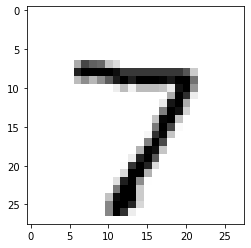

pred: 7, prob: 0.99, true: 7


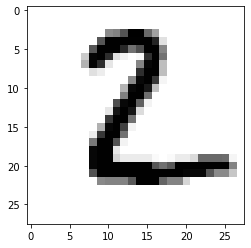

pred: 8, prob: 0.52, true: 2


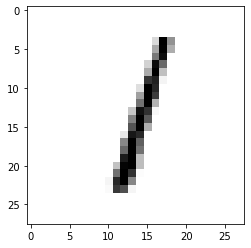

pred: 1, prob: 0.95, true: 1


In [18]:
import matplotlib.pyplot as plt
for test, true in zip(x_test[:3], y_test[:3]):
    image = np.reshape(test, (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()
    pred = net.predict(test)[0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    print('pred: %s, prob: %.2f, true: %d' % (idx, pred[0][idx], idx_true))

In [19]:
from sklearn.metrics import classification_report

In [20]:
from sklearn.metrics import classification_report
def evaluate(x_test, y_test):
  true = [np.argmax(y) for x, y in zip(x_test, y_test)]
  report = classification_report(true, [np.argmax(net.predict(x)[0]) for x, y in zip(x_test, y_test)])
  print(report)
evaluate(x_test, y_test)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       980
           1       0.98      0.93      0.95      1135
           2       0.82      0.82      0.82      1032
           3       0.86      0.73      0.79      1010
           4       0.84      0.67      0.74       982
           5       0.65      0.75      0.69       892
           6       0.85      0.70      0.77       958
           7       0.88      0.79      0.83      1028
           8       0.70      0.70      0.70       974
           9       0.54      0.86      0.67      1009

    accuracy                           0.79     10000
   macro avg       0.80      0.78      0.79     10000
weighted avg       0.81      0.79      0.79     10000



In [21]:
import pandas as pd
data = pd.read_csv('C:/Users/340/Desktop/Breast_cancer_data.csv')

In [22]:
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [23]:
data.var().round(3)
data.rename(columns={'Breast_cancer_data': 'mean_radius'}, inplace=True)

x = data.drop(columns='mean_radius')
y = data['diagnosis']

In [24]:
#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

# load MNIST from server
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

x_train.var().round(3)

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.values.reshape(x_train.shape[0], 1, 5)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.values.reshape(x_test.shape[0],1,5)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(5, 100))            
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(100, 50))                   
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(50, 2))                   
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

epoch 1/35   error=0.200854
epoch 2/35   error=0.130627
epoch 3/35   error=0.107712
epoch 4/35   error=0.100306
epoch 5/35   error=0.097051
epoch 6/35   error=0.095323
epoch 7/35   error=0.094293
epoch 8/35   error=0.093629
epoch 9/35   error=0.093170
epoch 10/35   error=0.092831
epoch 11/35   error=0.092567
epoch 12/35   error=0.092347
epoch 13/35   error=0.092157
epoch 14/35   error=0.091984
epoch 15/35   error=0.091822
epoch 16/35   error=0.091668
epoch 17/35   error=0.091518
epoch 18/35   error=0.091372
epoch 19/35   error=0.091229
epoch 20/35   error=0.091089
epoch 21/35   error=0.090951
epoch 22/35   error=0.090816
epoch 23/35   error=0.090685
epoch 24/35   error=0.090557
epoch 25/35   error=0.090433
epoch 26/35   error=0.090312
epoch 27/35   error=0.090195
epoch 28/35   error=0.090081
epoch 29/35   error=0.089972
epoch 30/35   error=0.089865
epoch 31/35   error=0.089763
epoch 32/35   error=0.089664
epoch 33/35   error=0.089568
epoch 34/35   error=0.089476
epoch 35/35   error=0.0

In [25]:
evaluate(x_test, y_test)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        70
           1       0.87      0.92      0.90       118

    accuracy                           0.87       188
   macro avg       0.86      0.85      0.85       188
weighted avg       0.87      0.87      0.87       188

